# Dual PMF Estimation As An Intermediate Step
This physics based approach estimates the pathlength PMF of the fetal layer as an intermediate step before estimating the saturation and fetal Hb Concentration. The input to this model should ideally be an interpolated version of I2/I1

## Loading Up the Data

In [1]:
from inverse_modelling_tfo.model_training.custom_models import DualPMFTMPNet
from pathlib import Path
import json
import pandas as pd
from model_trainer import HoldOneOut, RandomSplit, DataLoaderGenerator, ModelTrainer, TorchLossWrapper
from torch.optim import SGD
from model_trainer import ModelTrainer, RandomSplit, TorchLossWrapper, DataLoaderGenerator3
import torch.nn as nn
import matplotlib.pyplot as plt 
from inverse_modelling_tfo.data_merger_routines import merge_l4_dist

plt.style.use('seaborn-whitegrid')

# Load the exp terms data
l4_dist_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "l4_bins.pkl"
l4_dist_config_path = l4_dist_data_path.with_suffix('.json')
with open(l4_dist_config_path, 'r') as file:
    l4_dist_config = json.load(file)
chosen_detector_index = l4_dist_config['chosen_detector_index']
l4_dist_columns = l4_dist_config['features']
l4_bin_centers = [float(x) for x in l4_dist_columns]

# Load the log intensity data
i1_and_i2_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "I1_and_I2_interp.pkl"
i1_and_i2 = pd.read_pickle(i1_and_i2_data_path)
i1_and_i2_config_path = i1_and_i2_data_path.with_suffix('.json')
with open(i1_and_i2_config_path, 'r') as file:
    i1_and_i2_config = json.load(file)
intensity_columns = i1_and_i2_config['features']

data = merge_l4_dist(l4_dist_data_path, i1_and_i2)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Create the excess column
wv1_ppath_columns = [col + " WV1" for col in l4_dist_columns]
wv2_ppath_columns = [col + " WV2" for col in l4_dist_columns]
data['excess WV1'] = 1.0 - data[wv1_ppath_columns].sum(axis=1)
data['excess WV2'] = 1.0 - data[wv2_ppath_columns].sum(axis=1)
wv1_ppath_columns += ['excess WV1']     # update the columns
wv2_ppath_columns += ['excess WV2']    # update the columns

## Defining I/O and Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
## I/O
x_columns_wv1 = [col for col in intensity_columns if f'_1.0_' in col]
x_columns_wv2 = [col for col in intensity_columns if f'_2.0_' in col]
x_columns = x_columns_wv1 + x_columns_wv2

intermediate_columns = wv1_ppath_columns + wv2_ppath_columns

y_columns = ["Fetal Saturation", "Fetal Hb Concentration 1", "Fetal Hb Concentration 2"]

In [5]:
## Scaling
x_scaler = StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

# intermediate_columns are PMFs -> DO NOT SCALE
y_scaler = StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Creating A Custom Loss

In [6]:
from typing import List
from model_trainer.loss_funcs import DATA_LOADER_LABEL_INDEX, LossFunction, LossVisualizerMixin, SumLoss
from model_trainer.core import DATA_LOADER_EXTRA_INDEX
from torch.nn.functional import mse_loss

# Need to create custom loss function with custom __call__ methods
class PMFLoss(LossFunction, LossVisualizerMixin):
    def __init__(self):
        super().__init__('pmf')
    
    def __str__(self):
        return 'PMF Loss'

    def __call__(self, model_output, dataloader_data, trainer_mode):
        predicted_pmf = model_output[0]
        true_pmf = dataloader_data[DATA_LOADER_EXTRA_INDEX]
        loss = mse_loss(predicted_pmf, true_pmf)

        self.loss_tracker_step_update(loss.item(), trainer_mode)
        return loss

class TMPLoss(LossFunction, LossVisualizerMixin):
    def __init__(self, column_indices: List[int], name='tmp'):
        super().__init__(name)
        self.column_indices = column_indices
    
    def __str__(self):
        return f'TMP Loss on columns: {self.column_indices}'

    def __call__(self, model_output, dataloader_data, trainer_mode):
        predicted_tmp = model_output[1][:, self.column_indices]
        true_tmp = dataloader_data[DATA_LOADER_LABEL_INDEX][:, self.column_indices]
        loss = mse_loss(predicted_tmp, true_tmp)

        self.loss_tracker_step_update(loss.item(), trainer_mode)
        return loss

## Creating The Network

In [7]:
from model_trainer import DataLoaderGenerator3
from torch.optim import SGD

criterion1 = PMFLoss()
criterion2 = TMPLoss([1, 2], 'hb_conc')
criterion3 = TMPLoss([0], 'fetal_sat')
criterion = SumLoss([criterion1, criterion2, criterion3], [1.0, 1.0, 1.0])

datagen = DataLoaderGenerator3(data, x_columns, y_columns, intermediate_columns, batch_size=512)
validation_method = RandomSplit(0.7)
model = DualPMFTMPNet([len(x_columns)//2, 20, len(wv1_ppath_columns)], [15, 10, 3, len(y_columns)])
trainer = ModelTrainer(model, datagen, validation_method, criterion)

In [8]:
trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.9, 'nesterov': True})
trainer.run(20)

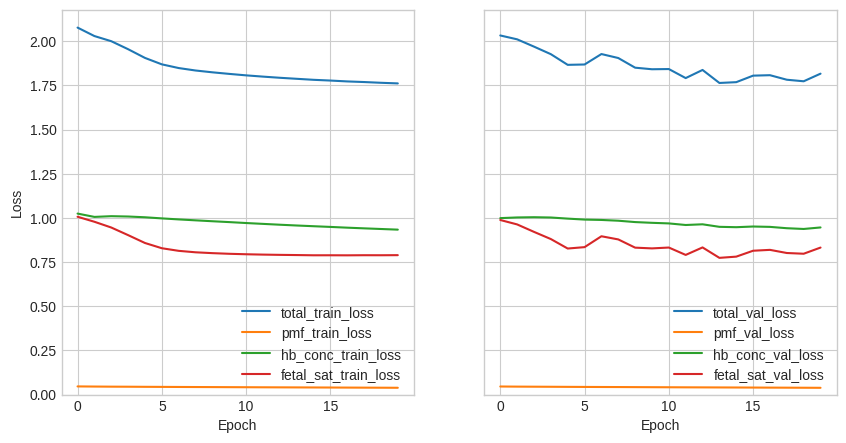

In [9]:
fig = criterion.plot_losses('split')

In [10]:
criterion.print_table()

                   Losses                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃    👀     ┃ Train Loss ┃ Validation Loss ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│   total   │   1.7613   │     1.8164      │
│    pmf    │   0.0386   │     0.0384      │
│  hb_conc  │   0.9336   │     0.9460      │
│ fetal_sat │   0.7892   │     0.8321      │
└───────────┴────────────┴─────────────────┘

In [11]:
import torchinfo

torchinfo.summary(model, input_size=(1024, len(x_columns)))

Layer (type:depth-idx)                   Output Shape              Param #
DualPMFTMPNet                            [1024, 22]                --
├─PMFEstimatorNet: 1-1                   [1024, 11]                --
│    └─Sequential: 2-1                   [1024, 11]                --
│    │    └─Linear: 3-1                  [1024, 20]                820
│    │    └─BatchNorm1d: 3-2             [1024, 20]                40
│    │    └─ReLU: 3-3                    [1024, 20]                --
│    │    └─Linear: 3-4                  [1024, 11]                231
│    │    └─Flatten: 3-5                 [1024, 11]                --
│    │    └─Sigmoid: 3-6                 [1024, 11]                --
├─PMFEstimatorNet: 1-2                   [1024, 11]                --
│    └─Sequential: 2-2                   [1024, 11]                --
│    │    └─Linear: 3-7                  [1024, 20]                820
│    │    └─BatchNorm1d: 3-8             [1024, 20]                40
│    │    └─